Importing dependencies

In [1]:
import numpy as np
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt

Constants

In [2]:
BATCH_SIZE = 100
IMAGE_SIZE = 50
CHANNELS=3
EPOCHS=50

### Data Collection

Import data into tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Datathon-Dataset",
    seed=100,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3224 files belonging to 4 classes.


### Exploratory Data Analysis (EDA) 

In [4]:
class_names = dataset.class_names
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


Number of classes: 4
Class names: ['category1_tumor', 'category2_tumor', 'category3_tumor', 'no_tumor']


In [5]:
from collections import Counter

class_counts = Counter()
for images, labels in dataset:
  class_counts.update(labels.numpy())

#images per class
for class_name, count in class_counts.items():
  print(f"{class_name, class_names[class_name]}: {count} images")


(3, 'no_tumor'): 490 images
(2, 'category3_tumor'): 891 images
(1, 'category2_tumor'): 927 images
(0, 'category1_tumor'): 916 images


In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch)

(100, 50, 50, 3)
tf.Tensor(
[1 3 0 3 0 1 3 3 2 0 3 2 0 0 2 2 2 2 1 2 1 3 2 3 0 2 1 2 1 2 3 0 1 0 0 2 2
 3 1 0 2 1 3 2 3 0 0 2 2 2 0 3 2 2 0 2 3 2 1 2 2 2 2 2 1 1 0 0 2 2 0 3 2 2
 0 1 1 0 1 0 0 0 0 2 1 0 0 1 0 1 0 0 1 3 1 3 0 1 2 1], shape=(100,), dtype=int32)


First image as a Tensor

In [7]:
image_batch[0]

<tf.Tensor: shape=(50, 50, 3), dtype=float32, numpy=
array([[[0.27999997, 0.27999997, 0.27999997],
        [0.36960012, 0.36960012, 0.36960012],
        [1.        , 1.        , 1.        ],
        ...,
        [0.17599733, 0.17599733, 0.17599733],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.    

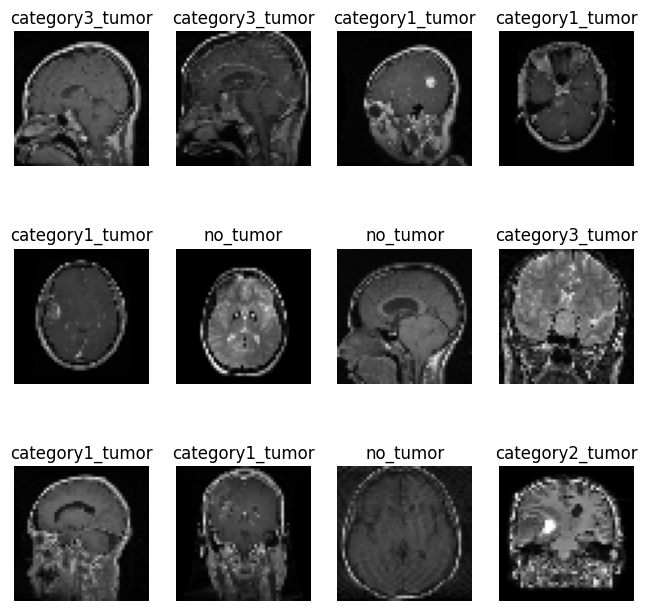

In [8]:
plt.figure(figsize=(8, 8))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Data Preparation and Pre-processing

Handling with unbalanced data

In [9]:
def augment(image, label):
  # Apply a random horizontal flip to the image with probability 0.5
  image = tf.image.random_flip_left_right(image)
  
  return image, label

# Oversample the class samples by applying the augment function
dataset = dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)


<b>  Train test Split</b>

Training (70%): Dataset to be used while training

Validation (15%): Dataset to be tested against while training

Test (15%): Dataset to be tested against after we trained a model

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=100)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Train set

In [12]:
len(train_ds)

23

Validation set

In [13]:
len(val_ds)

4

Test set

In [14]:
len(test_ds)

6

Improving performance using Cache, Shuffle, and Prefetch

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Preprocessing by Resizing and Rescaling

In [16]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])


Image augmentation (Flipping and Rotation)

In [17]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
# ])

Applying Data Augmentation to Train Dataset

In [18]:
# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

Handling overfitting

In [19]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

### Model training

CNN model

In [20]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,

    layers.BatchNormalization(),
    layers.Conv2D(filters=50, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(.25), #dropout layer to reduce noise

    layers.Flatten(),
    layers.Dense(100, activation='relu'), # fully connected layer with 100 units and ReLU activation
    layers.Dropout(.25),
    layers.Dense(200, activation='relu'),# fully connected layer with 200 units and ReLU activation
    layers.Dropout(.25),
    layers.Dense(300, activation='relu'), # fully connected layer with 300 units and ReLU activation
    layers.Dropout(.25),
    layers.Dense(4, activation='softmax') #Output layer with 4 units (for 4 classes)
])

model.build(input_shape=input_shape)

Model Architecture Diagram

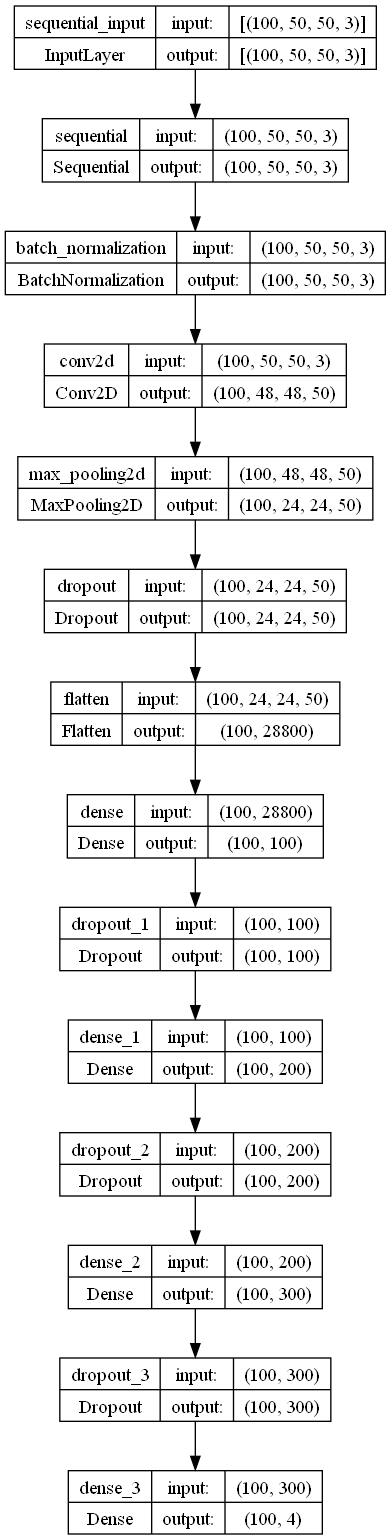

In [21]:
from keras.utils.vis_utils import plot_model

# Generate the architectural diagram and save it as an image
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (100, 50, 50, 3)          0         
                                                                 
 batch_normalization (BatchN  (100, 50, 50, 3)         12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (100, 48, 48, 50)         1400      
                                                                 
 max_pooling2d (MaxPooling2D  (100, 24, 24, 50)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (100, 24, 24, 50)         0         
                                                                 
 flatten (Flatten)           (100, 28800)             

Compiling the CNN model

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/50


23/23 [==============================] - 8s 237ms/step - loss: 1.3364 - accuracy: 0.4424 - val_loss: 1.3528 - val_accuracy: 0.2375
Epoch 2/50
23/23 [==============================] - 4s 155ms/step - loss: 0.8971 - accuracy: 0.6174 - val_loss: 1.2888 - val_accuracy: 0.2950
Epoch 3/50
23/23 [==============================] - 3s 151ms/step - loss: 0.7607 - accuracy: 0.6695 - val_loss: 1.1496 - val_accuracy: 0.5725
Epoch 4/50
23/23 [==============================] - 4s 156ms/step - loss: 0.6366 - accuracy: 0.7226 - val_loss: 0.9593 - val_accuracy: 0.6875
Epoch 5/50
23/23 [==============================] - 4s 175ms/step - loss: 0.6266 - accuracy: 0.7469 - val_loss: 0.8953 - val_accuracy: 0.7550
Epoch 6/50
23/23 [==============================] - 4s 167ms/step - loss: 0.5117 - accuracy: 0.7950 - val_loss: 0.7215 - val_accuracy: 0.8075
Epoch 7/50
23/23 [==============================] - 4s 155ms/step - loss: 0.4470 - accuracy: 0.8188 - val_loss: 0.6739 - val_accuracy: 0.7925
Epoch 8/50
23/23 

### Testing and Evaluation

In [25]:
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

6/6 [==============================] - 1s 30ms/step - loss: 0.3272 - accuracy: 0.8817
Test accuracy: 0.8816666603088379
Test loss: 0.32724878191947937


Saving the model

In [26]:
# Save the model
model.save('model.h5')

Evaluations

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Accuracy plot and Loss plot

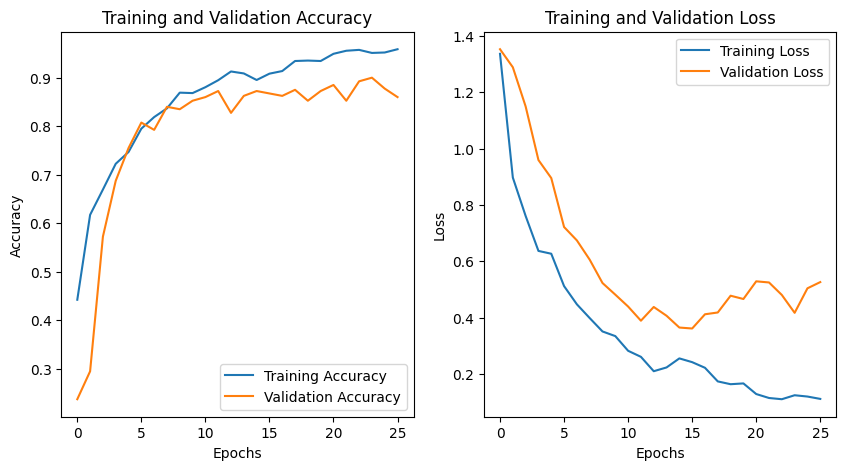

In [28]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Prediction for test dataset

In [29]:
for images_batch, labels_batch in test_ds:    
    prediction = model.predict(images_batch)

y_pred_classes = [np.argmax(i) for i in prediction]
y_pred_classes[:5]

4/4 [==============================] - 0s 11ms/step


[3, 3, 2, 3, 3]

Classification report

In [30]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(labels_batch, y_pred_classes, target_names=class_names))

                 precision    recall  f1-score   support

category1_tumor       0.88      0.85      0.87        27
category2_tumor       0.94      0.91      0.92        32
category3_tumor       1.00      1.00      1.00        27
       no_tumor       0.88      1.00      0.93        14

       accuracy                           0.93       100
      macro avg       0.92      0.94      0.93       100
   weighted avg       0.93      0.93      0.93       100



Confusion Matrix

Text(33.22222222222222, 0.5, 'Truth')

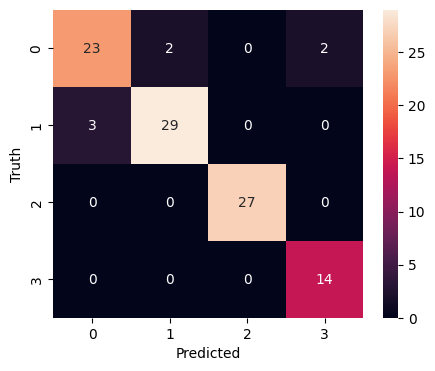

In [31]:
import seaborn as sn
cm = confusion_matrix(labels_batch, y_pred_classes)

plt.figure(figsize = (5,4))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Predicting on a sample image

First image to predict
Actual label: category1_tumor
4/4 [==============================] - 0s 10ms/step
Predicted label: category1_tumor


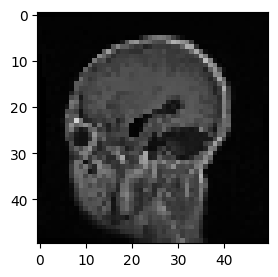

In [32]:
model = tf.keras.models.load_model('model.h5')

for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.figure(figsize=(3, 3))
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])